# Image Classification -- Imagewoof
> This notebook demonstrates various techniques of effective Neural Network models training using the Callbacks mechanism of FastAI library (v1).

[`Imagewoof` dataset](https://github.com/fastai/imagenette)


## Getting the Data

In [0]:
from fastai.vision import *

In [0]:
path = untar_data('https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2') 

We will decode the dataset labels to be more meaningful to a human.

In [0]:
lbl_dict = dict(
  n02093754='Australian terrier', 
  n02089973='Border terrier', 
  n02099601='Samoyed', 
  n02087394='Beagle', 
  n02105641='Shih-Tzu', 
  n02096294='English foxhound', 
  n02088364='Rhodesian ridgeback', 
  n02115641='Dingo', 
  n02111889='Golden retriever', 
  n02086240='Old English sheepdog'
)

def lbl_trfm(o): 
  return lbl_dict[str(o).split('/')[-2]] # Use folder name of image object `o`

### Data augmentation
Instead of feeding the model with the same pictures every time, we do small random transformations (a bit of rotation, zoom, translation, etc...) that don't change what's inside the image (to the human eye) but do change its pixel values. Models trained with data augmentation will then generalize better.

In [62]:
tfms = get_transforms()
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

Let's pull together the data into a singe `ImageDataBunch` object.

In [0]:
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_func(lbl_trfm)
        .transform(tfms, size=160)
        .databunch(bs=32)
        .normalize(imagenet_stats))

In [64]:
data

ImageDataBunch;

Train: LabelList (9025 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
Australian terrier,Australian terrier,Australian terrier,Australian terrier,Australian terrier
Path: /root/.fastai/data/imagewoof2;

Valid: LabelList (3929 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
Australian terrier,Australian terrier,Australian terrier,Australian terrier,Australian terrier
Path: /root/.fastai/data/imagewoof2;

Test: None

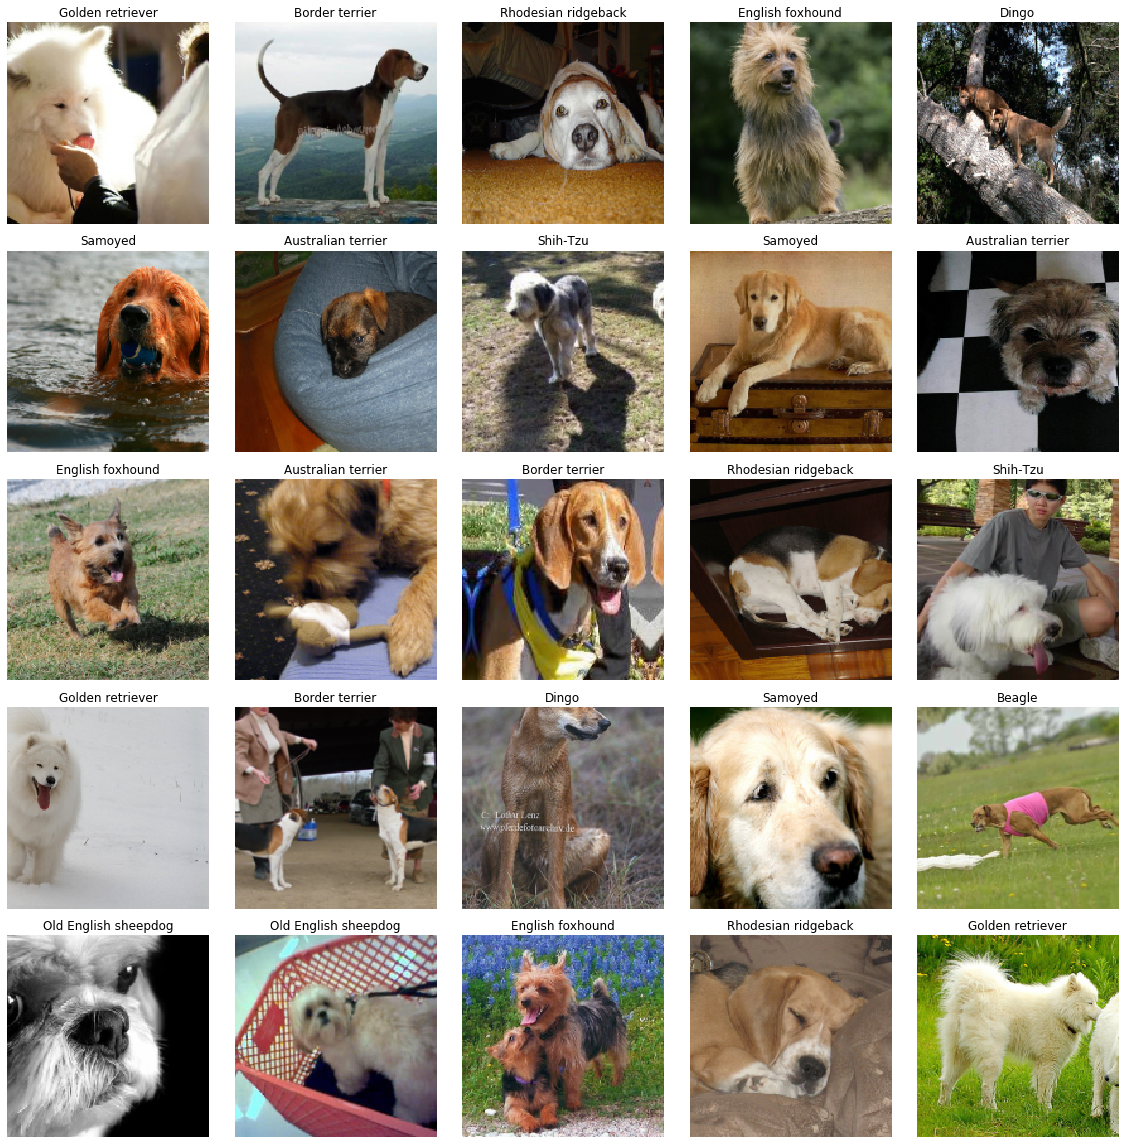

In [65]:
data.show_batch(5, figsize=(16,16))

## Randomly Initialized CONV Model

In [0]:
results = pd.DataFrame(index=range(5))

In [67]:
int(torch.cuda.max_memory_allocated(0)/(1024*1024))

4627

In [0]:
from fastai.callbacks import *

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], pretrained=False, callback_fns=[CSVLogger,ShowGraph])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


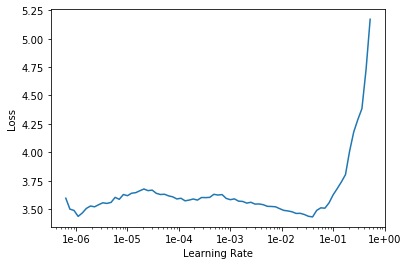

In [34]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,2.748060,3.147827,0.166455,03:03
1,2.625360,3.451415,0.173836,03:02
2,2.470364,2.222389,0.196997,03:02
3,2.258959,2.040264,0.260372,03:00
4,2.075738,1.975030,0.312548,03:02


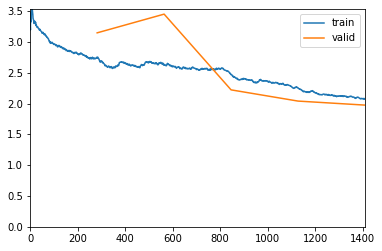

In [35]:
learn.fit_one_cycle(5,max_lr=5e-3)

In [0]:
results['resnet50'] = pd.read_csv(path/'history.csv',usecols=['accuracy'])
results.head()

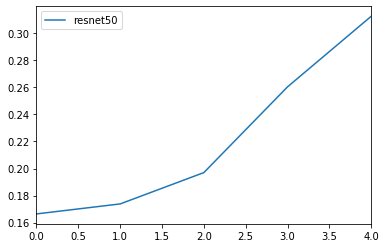

In [45]:
results.plot()

## Pretrained CONV net Model

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], pretrained=True, callback_fns=[CSVLogger,ShowGraph])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


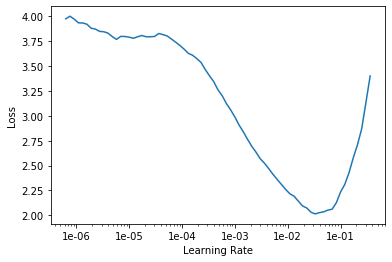

In [70]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.567119,0.337504,0.903029,03:01
1,0.414245,0.303489,0.909137,03:02
2,0.296347,0.235700,0.929244,03:01
3,0.226097,0.204954,0.937389,03:00
4,0.189701,0.203582,0.937898,02:59


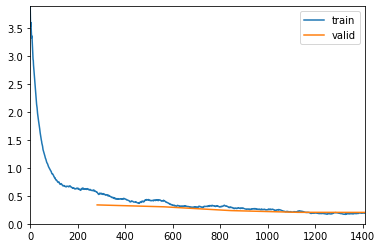

In [71]:
learn.fit_one_cycle(5,max_lr=slice(2e-4,2e-3,2e-2))

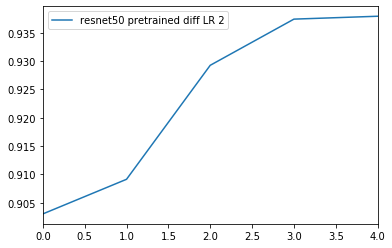

In [72]:
results['resnet50 pretrained diff LR 2'] = pd.read_csv(path/'history.csv',usecols=['accuracy'])
results.plot()

## Results

In [73]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

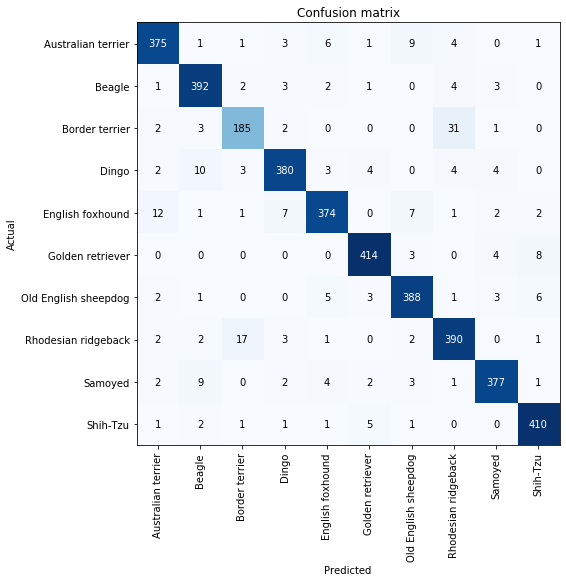

In [74]:
interp.plot_confusion_matrix(figsize=(8,8))

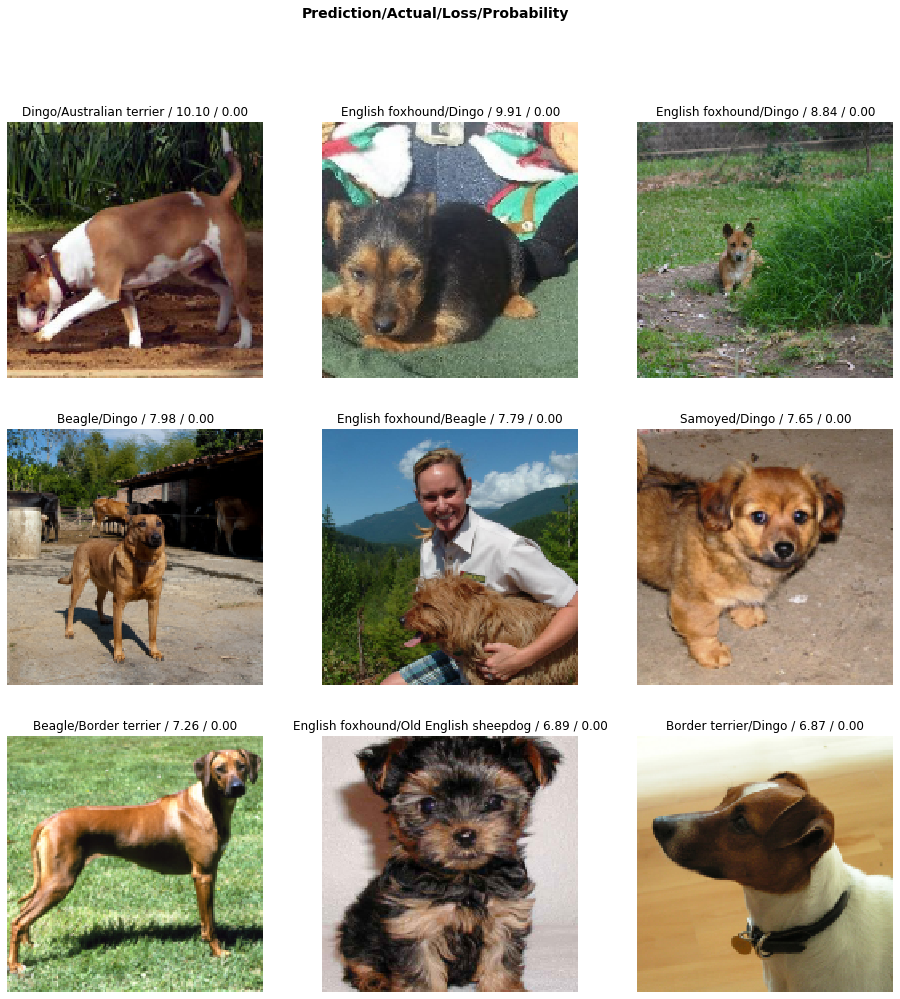

In [51]:
interp.plot_top_losses(9, figsize=(16,16))